In [5]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt

<xarray.Dataset> Size: 12kB
Dimensions:      (depth_index: 115, doy: 12)
Coordinates:
  * depth_index  (depth_index) int64 920B 1 2 3 4 5 6 ... 111 112 113 114 115
  * doy          (doy) float64 96B 15.0 45.0 75.0 105.0 ... 285.0 315.0 345.0
Data variables:
    temp_c       (depth_index, doy) float64 11kB 16.4 15.27 15.11 ... nan nan

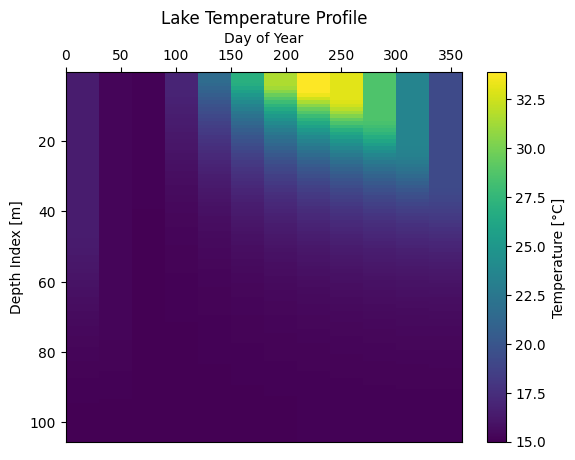

In [75]:
# Load lake data
lakedata =  xr.open_dataset('PyramidLake_105m.nc')

fig, prof = plt.subplots()
lakedata['temp_c'].dropna(dim='depth_index').plot()
prof.xaxis.set_label_position('top')
prof.invert_yaxis()
prof.xaxis.tick_top()
plt.title('Lake Temperature Profile')
plt.xlabel('Day of Year')
plt.ylabel('Depth Index [m]')
cbar = prof.collections[0].colorbar
cbar.set_label('Temperature [°C]')

lakedata

In [7]:
def clumped_sensor(temp_c, model):
        if model == 'I-CDES90':
            cap47 = 0.0004 * 10**6 / (temp_c + 273.15)**2 + 0.154 # Anderson et al 2021 I-CDES90 ref frame (w/ conversion from Celcius to Kelvin) # not including +/- uncertainties, can add later
        elif model == 'CDES90': 
            cap47 = 1  # will add other functions
        else:
            raise ValueError('Model not recognized')
        
        return cap47.to_numpy()

In [8]:
#Inverse of clumped_sensor functions to return temperature from final clumped value
def clumped_temperature(cap47, model):
        if model == 'I-CDES90':
           temp_c = ((0.0004 * (10**6) / (cap47 - 0.154))**0.5) - 273.15
        elif model == 'CDES90': 
            temp_c = 1  # will add other functions
        else:
            raise ValueError('Model not recognized')
        
        return temp_c.to_numpy()

In [9]:
def generate_depth_weights(depth, weight_type):
    """
    Generate a depth-weighting function.

    Args:
        depths (pd.DataFrame): Array or DataFrame column of depth values.
        weight_type (str): Equation type for computing the weighting with depth.

    Returns:
        np.ndarray: Array of weights aligned with the depth values.
    """
    if weight_type == 'uniform':
        weights = [1 if not pd.isna(val) else np.nan for val in depth] # Initialize all weights to 1
        weights = pd.DataFrame(weights, columns=['depth_weights'])
    
    elif weight_type == 'surface':
        weights = [0 if not pd.isna(val) else np.nan for val in depth] # Initialize all weights to 0
        weights[0] = 1  # Assign weight of 1 to the first element
        weights = pd.DataFrame(weights, columns=['depth_weights'])
  
    elif weight_type == 'step':
        depth_min = X  # Set your desired minimum depth
        depth_max = X  # Set your desired maximum depth

        conditions = [
            depth.isna(),
            (depth >= depth_min) & (depth <= depth_max)
        ]
        choices = [np.nan, 1]
        weights = np.select(conditions, choices, default=0)
        weights = pd.DataFrame(weights, index=depth.index, columns=['depth_weights'])

    elif weight_type == 'normal_dist':
        mask = ~depth.isna()
        depth_clean = depth[mask]
        depth_index_mean = round(depth_clean.values.mean(), 2)
        depth_index_std = round(depth_clean.values.std(), 2)
        weights_clean = (1 / (depth_index_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((depth_clean - depth_index_mean) / depth_index_std) ** 2)
        # Normalize the weights so they sum to 1
        weights_clean /= weights_clean.sum()
        weights = np.full_like(depth, np.nan, dtype=np.float64)
        weights[mask] = weights_clean
        weights = pd.DataFrame(weights, index=depth.index, columns=['depth_weights'])
        
    else:
        raise ValueError('Weight type not recognized')
    
    return weights

In [69]:
def generate_time_weights(timesteps, weight_type, selected_months=None): 
    """
    Generate a time-weighting function.

    Args:
        depths (pd.DataFrame): DataFrame column of depth values.
        weight_type (str): Equation type for computing the weighting with doy.
        selected_months (list): List of months to apply the '' weighting function to (e.g. selected_months=['January', 'February']), otherwise 'None'.

    Returns:
        np.ndarray: Array of weights aligned with doy values.
    """
    months = {
        'MAMJ': (60, 182),  # March to June
        'AMJ': (91, 182),  # April to June  
        'AMJJ': (91, 213),  # April to July
        'AMJJASO': (91, 305),  # April to October
        'JJA': (152, 244),  # July to August 
        'ASO': (213, 305),  # August to October
        'January': (0, 32),
        'February': (32, 60),
        'March': (60, 91),
        'April': (91, 121),
        'May': (121, 152),
        'June': (152, 182),
        'July': (182, 213),
        'August': (213, 244),
        'September': (244, 274),
        'October': (274, 305),
        'November': (305, 335),
        'December': (335, 366)
        }
    
    if weight_type == 'uniform':
        weights = [1] * len(timesteps)  # Initialize all weights to 1
        
    
    elif weight_type == 'range':
        # ... check to see if any selected months don't occur in the months dict
        #     return a message to let the user know (maybe they mis-spelled something)
        missing_keys = [key for key in selected_months if key not in months]
        if missing_keys:
            print(f"Warning: selected month option(s) {missing_keys} is not valid. Please select from {list(months.keys())}")

        # ... filter the months dict for just the selected months
        selected_months_dict = {key: months[key] for key in selected_months if key in months}

        # ... return 1 if the timestep is within one of the ranges, return 0 otherwise
        weights = [1 if any(start <= num <= end for start, end in selected_months_dict.values()) else 0 for num in timesteps]

    elif weight_type == 'normal_dist':
        time_index_mean = round(timesteps.values.tolist().mean(), 2)
        time_index_std = round(timesteps.values.tolist().std(), 2)
        weights = (1 / (time_index_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((timesteps - time_index_mean) / time_index_std) ** 2)
        # Normalize the weights so they sum to 1
        weights /= weights.sum()
        weights = pd.DataFrame(weights, index=timesteps.index, columns=['time_weights'])
    else:
        raise ValueError('Weight type not recognized')
    
    return weights

T47_c MAT: 16.71034937253751


<xarray.Dataset> Size: 32kB
Dimensions:                (doy: 12, depth_index: 105)
Coordinates:
  * doy                    (doy) float64 96B 15.0 45.0 75.0 ... 315.0 345.0
  * depth_index            (depth_index) int64 840B 1 2 3 4 ... 102 103 104 105
Data variables:
    cap47                  (doy, depth_index) float64 10kB 0.1588 ... 0.1588
    temp_c_depth_wtd_mean  (doy) float64 96B 16.4 15.27 15.11 ... 23.48 19.23
    cap47_depth_wtd_mean   (doy) float64 96B 0.1588 0.1588 ... 0.1587 0.1588
    T47_c_depth_wtd_mean   (doy) float64 96B 15.96 15.24 15.05 ... 17.83 17.03
    time_weights           (doy) int64 96B 1 1 1 1 1 1 1 1 1 1 1 1
    cap47_time_wtd_mean    float64 8B 0.1588
    T47_c_MAT              float64 8B 16.71
    temp_c                 (depth_index, doy) float64 10kB 16.4 15.27 ... 15.07
    depth_weights          (doy, depth_index) float64 10kB 0.003296 ... 0.003296

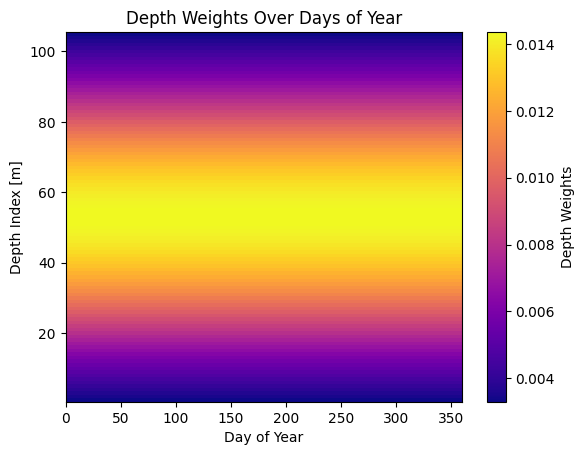

In [73]:
def process_lake_data(lakedata):
    timesteps = lakedata['doy'].values.tolist()
    cap47 = []

    for ts in (timesteps) :
        tmpds = lakedata.sel(doy = ts) # pull out this timestep
        tmpdf = tmpds.to_dataframe().reset_index()  # convert it to pandas df

        temp_c = pd.DataFrame(tmpdf['temp_c'])['temp_c']
        depth = pd.DataFrame(tmpdf['depth_index'])['depth_index']
        
        ts_cap47 = clumped_sensor(temp_c, 'I-CDES90')
        ts_cap47 = pd.DataFrame(ts_cap47).copy()
        ts_cap47 = ts_cap47.rename(columns={'temp_c': 'cap47'})
        cap47.append(ts_cap47)
        nan_count = temp_c[::-1].isna().cumprod().sum()
        depth.iloc[-nan_count:] = np.nan 

        depth_weights = generate_depth_weights(depth, 'normal_dist')  
        depth_weights = pd.DataFrame(depth_weights.values.flatten())
       
        if ts == timesteps[0]:
            df = pd.DataFrame(tmpdf['doy'].values, columns=['doy'])
            cap47_depth_wtd_mean = (ts_cap47.values * depth_weights).sum() / depth_weights.sum()
            temp_c_depth_wtd_mean = (temp_c * depth_weights).sum() / depth_weights.sum()
            df = df.assign(temp_c_depth_wtd_mean = temp_c_depth_wtd_mean).dropna()
            df = df.assign(cap47_depth_wtd_mean = cap47_depth_wtd_mean).dropna()
        else:
            tdf = pd.DataFrame(tmpdf['doy'].values, columns=['doy'])
            cap47_depth_wtd_mean = (ts_cap47.values * depth_weights).sum() / depth_weights.sum()
            temp_c_depth_wtd_mean = (temp_c * depth_weights).sum() / depth_weights.sum()
            tdf = tdf.assign(temp_c_depth_wtd_mean = temp_c_depth_wtd_mean).dropna()
            tdf = tdf.assign(cap47_depth_wtd_mean = cap47_depth_wtd_mean).dropna()
            df = pd.concat([tdf, df], ignore_index=True)
            df = df.dropna()      

    T47_c_depth_wtd_mean = clumped_temperature(df['cap47_depth_wtd_mean'], 'I-CDES90')

    df = df.set_index('doy', drop=True)
    df = df.assign(T47_c_depth_wtd_mean = T47_c_depth_wtd_mean)
    df = xr.Dataset.from_dataframe(df)
    time_weights = generate_time_weights(timesteps, 'uniform') 
    time_weights = time_weights[::-1]
    df = df.assign(time_weights=(['doy'], time_weights))
    df['cap47_time_wtd_mean'] = (df['cap47_depth_wtd_mean']* df['time_weights']).sum() / df['time_weights'].sum()
    df['T47_c_MAT'] = (df['T47_c_depth_wtd_mean'] * df['time_weights']).sum() / df['time_weights'].sum()    

    final_output_init = xr.combine_by_coords([df, lakedata])

    final_output_init = final_output_init.assign(depth_weights=(['depth_index'], depth_weights.to_numpy().flatten()))
    
    ds_cap47 = xr.Dataset(
    {
        "cap47": (["doy", "depth_index"], np.stack([df[0].values for df in cap47]))
    },
    coords={"doy": final_output_init['doy'].values, "depth_index": final_output_init['depth_index'].values}
    )

    final_output = xr.merge([ds_cap47, final_output_init])
    depth_weights_expanded = np.tile(final_output['depth_weights'], (len(final_output['doy']), 1))
    final_output["depth_weights"] = (['doy', 'depth_index'], depth_weights_expanded)
    final_output = final_output.dropna(dim='depth_index', how='all')
    return final_output

final_output = process_lake_data(lakedata)

#Figure 1: Depth Weights Over Days of Year
Fig_1 = final_output['depth_weights'].transpose().plot(cmap='plasma')
plt.title('Depth Weights Over Days of Year')
plt.xlabel('Day of Year')
plt.ylabel('Depth Index [m]')
cbar = Fig_1.colorbar
cbar.set_label('Depth Weights')

print("T47_c MAT:", final_output['T47_c_MAT'].values)
final_output



Text(0, 0.5, 'T47 Depth Weighted Mean [°C]')

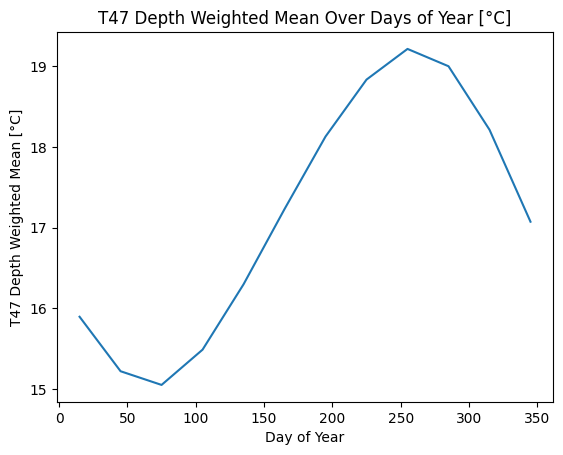

In [145]:
Fig_2 = final_output['T47_c_depth_wtd_mean'].plot()
plt.title('T47 Depth Weighted Mean Over Days of Year [°C]')
plt.xlabel('Day of Year')
plt.ylabel('T47 Depth Weighted Mean [°C]')